In [53]:
import numpy as np
from scipy.integrate import solve_ivp
from numba import njit
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt
from functions.kr_functions import log_points, ab_fraction

In [54]:
# constants #

ki = 1.2e-06 * 60 # 1/s
kp = 500 * 60 # L/mol*s
ktc = 6e06 * 60# L/mol*s
ktd = 0.0 * 60# 6e06 # L/mol*s
kfm = 9.1e-02 * 60# L/mol*s
kfp = 0.0 #0.5 * 60# L/mol*s
kpp = 0.05 * 60 # L/mol*s
f = 1.0
M0 = 8.4 # mol/L
I0 = 0.002 #mol/L

In [55]:
@njit
def lambda_0(I): # moment zero for radicals
    return np.sqrt((2 * f * ki * I) / (ktd + ktc))

@njit
def lambda_1(M, L0, mu_1, mu_2): # momento one for radicals
    num = kp * M * L0 + kfp * L0 * mu_2
    denm = kfm * M + (ktd + ktc) * L0 + kfp * mu_1
    
    return num / denm

In [56]:
n = log_points(100, 2, 1_000_000)

In [57]:
# Crear un array con 400 elementos para b de propagación
b_p = 1.0 / np.diff(n)
b_p = np.append(b_p, b_p[-1])

In [58]:
ai_dict, bi_dict = ab_fraction(n)

#### Con terminación por combinación

In [67]:
# Función principal
def balances_KR(t, y):
    
    # Descomposición del vector de estados
    I = y[0]
    M = y[1]
    mu_0 = y[2]
    mu_1 = y[3]
    mu_2 = y[4]
    Nrd = y[5:105]  # Radicales
    Npd = y[105:205]  # Polímeros

    # Cálculo de momentos de los radicales
    L0 = lambda_0(I)
    L1 = lambda_1(M, L0, mu_1, mu_2)

    # Ecuaciones diferenciales
    dIdt = -ki * I
    dMdt = -(kp + kfm) * M * L0
    dmu_0dt = kfm * M * L0 + (0.5 * ktc + ktd) * L0**2
    dmu_1dt = kp * M * L0
    dmu_2dt = 0.0 #kp * M * (L0 + 2 * L1) + ktc * L1**2

    # Ecuaciones para los radicales y polímeros
    dNrdt = np.zeros_like(Nrd)
    dNpdt = np.zeros_like(Npd)

    # Resolver para los radicales con QSSA
    A = np.zeros((len(Npd), len(Npd)))
    b = np.zeros(len(Npd))

    for idx in range(len(Npd)):
        if idx == 0:
            A[idx, idx] = -(kfm * M + (ktd + ktc) * L0 + kfp * mu_1) - kp * M * b_p[idx]
            b[idx] = -(kfm * M * L0 + 2 * f * ki * I + kfp * L0 * n[idx] * Npd[idx])
        else:
            A[idx, idx] = -(kfm * M + (ktd + ktc) * L0 + kfp * mu_1) - kp * M * b_p[idx]
            A[idx, idx-1] = kp * M * b_p[idx-1]
            b[idx] = -(kfp * L0 * n[idx] * Npd[idx])
    
    Nrd = solve_triangular(A, b, lower=True)

    for idx in range(len(Npd)):
        # Obtener los valores desde el diccionario o None si no existen
        ai_idx = ai_dict.get(idx, None)
        bi_idx = bi_dict.get(idx, None)

        # Inicializar sumas
        suma_1 = 0.0
        suma_2 = 0.0

        # Solo calcular si hay datos en ai_idx
        if ai_idx is not None and len(ai_idx) > 0:
            ai_idx = np.array(ai_idx)  # Convertir a array solo una vez
            idx_0, idx_1 = ai_idx[:, :2].astype(int).T  # Extraer y convertir las dos primeras columnas a int
            coef = ai_idx[:, 2]  # La tercera columna sigue como flotante

            suma_1 = np.sum(coef * Nrd[idx_0] * Nrd[idx_1])
            

        # Solo calcular si hay datos en bi_idx
        if bi_idx is not None and len(bi_idx) > 0:
            bi_idx = np.array(bi_idx)  # Convertir a array solo una vez
            idx_0, idx_1 = bi_idx[:, :2].astype(int).T  # Extraer y convertir las dos primeras columnas a int
            coef = bi_idx[:, 2]  # La tercera columna sigue como flotante

            suma_2 = np.sum(coef * Nrd[idx_0] * Nrd[idx_1])

        # Ecuación diferencial
        dNpdt[idx] = (- kfp * L0 * n[idx] * Npd[idx]
                    + (kfm * M + ktd * L0 + kfp * mu_1) * Nrd[idx]
                    + (ktc/2) * (suma_1 + suma_2))

    # Concatenación de derivadas
    return np.concatenate(([dIdt, dMdt, dmu_0dt, dmu_1dt, dmu_2dt], dNrdt, dNpdt))

In [68]:
y0 = np.zeros(205)
y0[0] = I0
y0[1] = M0

time = [0, 7500]
t_get = [100, 1000, 3500, 10000, 15000, 40000, 60000, 71100, 90000]

In [69]:
sol = solve_ivp(
      balances_KR,
      time, 
      y0, 
      #t_eval=t_get,
      method='LSODA',
      rtol=1e-08,
      atol=1e-010,
      )

In [62]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.403e-04 ...  7.321e+03  7.500e+03]
        y: [[ 2.000e-03  2.000e-03 ...  1.181e-03  1.165e-03]
            [ 8.400e+00  8.400e+00 ...  3.566e-02  3.175e-02]
            ...
            [ 0.000e+00  3.764e-35 ...  5.052e-29  5.052e-29]
            [ 0.000e+00  1.200e-36 ...  1.549e-30  1.549e-30]]
      sol: None
 t_events: None
 y_events: None
     nfev: 139
     njev: 0
      nlu: 0

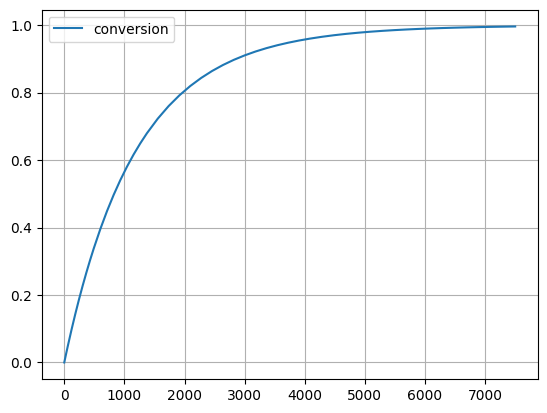

In [63]:
X = (M0 - sol.y[1]) / M0
plt.plot(sol.t, X, label="conversion")
plt.legend()
plt.grid()
plt.show()

In [64]:
sol.t.shape

(68,)

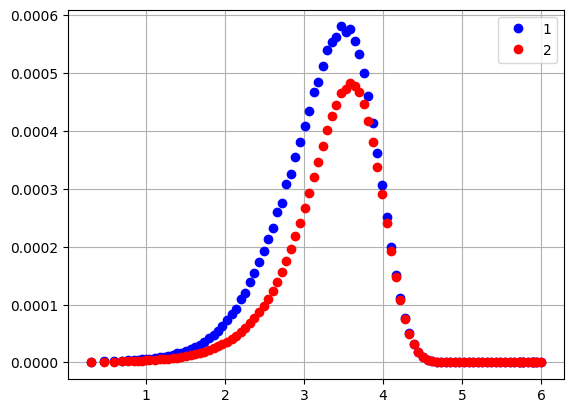

In [65]:
nlog = np.log10(n)
pn1 = sol.y[105:205, 67] / (1/b_p)
pn2 = sol.y[105:205, 40] / (1/b_p)

pn1n = np.multiply(pn1, n)
pn2n = np.multiply(pn2, n)

plt.plot(nlog, pn1n, 'ob', label='1')
plt.plot(nlog, pn2n, 'or', label = '2')
plt.grid()
plt.legend()

In [66]:
sol.y[1][67]

0.031746202086951905